# Neuroscape playground

In [90]:
# imports
from multiprocessing import Pool
import sys
sys.path.append("..")
import src
import jax
from jax import random, grad, jit, vmap, lax
import jax.numpy as jnp
import importlib
from matplotlib import pyplot as plt
import os
import numpy as np
import pandas as pd
from nilearn import datasets, plotting, maskers
from tqdm import tqdm
# black background

In [2]:
importlib.reload(src);
plt.style.use('dark_background')
plt.rcParams['font.family'] = 'Times New Roman'

## machine learning

In [72]:
n_steps = 100
batch_size = 32
n_samples = 1000

In [73]:

args_list = [
    '--model', 'fmri2cat',
    '--roi', 'V1d',
    '--machine', 'local',
    '--subject', 'subj05',
    '--batch_size', str(batch_size),
    '--n_samples', str(n_samples),
    '--n_steps', str(n_steps),
    ]

In [74]:
reload_data = True  # flip to false after first run
config, args = src.get_setup(args_list)
if reload_data:
    train_loader, val_loader, _ = src.get_loaders(args, config)
    next(train_loader), next(val_loader);

100%|██████████| 1000/1000 [00:28<00:00, 35.25it/s]


In [160]:
rng = jax.random.PRNGKey(0)
layer_sizes = [rh.shape[-1], 128, 128, 80]
params = src.model.init_mlp(layer_sizes, rng)
metrics = {'train_f1': [], 'val_f1': [], 'train_loss': [], 'val_loss': [], 'baseline_f1': [], 'baseline_loss': []}
freqs, n = np.zeros(80), 0

In [161]:
def loss_fn(params, x, y, pred=None):
    pred = src.model.forward_mlp(params, x) if pred is None else pred
    return -jnp.mean(y * jnp.log(pred) + (1 - y) * jnp.log(1 - pred))

def f1_score(params, x, y, pred=None):
    pred = src.model.forward_mlp(params, x) if pred is None else pred
    pred = pred > 0.5
    tp = jnp.sum(pred * y)
    fp = jnp.sum(pred * (1 - y))
    fn = jnp.sum((1 - pred) * y)
    return tp / (tp + 0.5 * (fp + fn))

def baseline(params, x, y, probs):
    pred = np.random.rand(*y.shape) < probs
    loss = loss_fn(params, x, y, pred)
    f1 = f1_score(params, x, y, pred)
    return loss, f1


grad_fn = jit(grad(loss_fn))

In [199]:
steps = 2000
for i in tqdm(range(steps)):
    img, cat, sup, cap, lh, rh = next(train_loader)
    freqs, n = freqs + np.sum(cat, axis=0), n + cat.shape[0]
    val_img, val_cat, val_sup, val_cap, val_lh, val_rh = next(val_loader)
    pred = src.model.forward_mlp(params, rh)
    grads = grad_fn(params, rh, cat)
    params = [(w - 0.01 * dw, b - 0.01 * db) for (w, b), (dw, db) in zip(params, grads)]
    loss = loss_fn(params, rh, cat)
    f1 = f1_score(params, rh, cat)
    val_loss = loss_fn(params, val_rh, val_cat)
    val_f1 = f1_score(params, val_rh, val_cat)
    baseline_loss, baseline_f1 = baseline(params, rh, cat, freqs / n)
    metrics['baseline_f1'].append(baseline_f1)
    metrics['baseline_loss'].append(baseline_loss)
    metrics['train_f1'].append(f1)
    metrics['val_f1'].append(val_f1)
    metrics['train_loss'].append(loss)
    metrics['val_loss'].append(val_loss)



# src.plot_metrics(metrics);

100%|██████████| 2000/2000 [01:04<00:00, 31.17it/s]


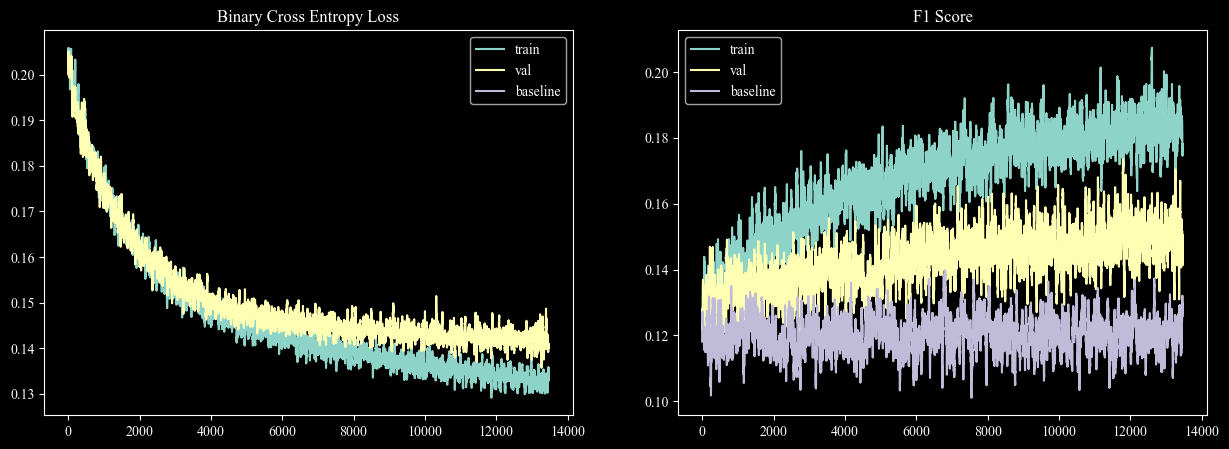

In [207]:

rolling_average = lambda lst: [np.mean(lst[i:i+30]) for i in range(len(lst) - 30)][1000:]

# params, metrics = src.train(params, metrics, config, args, train_loader, val_loader)
fig, axes = plt.subplots(1, 2, figsize=(15, 5), dpi=100)
axes[0].plot(rolling_average(metrics['train_loss']), label='train')
axes[0].plot(rolling_average(metrics['val_loss']), label='val')
axes[0].plot(rolling_average(metrics['baseline_loss']), label='baseline')
axes[0].set_title('Binary Cross Entropy Loss')
axes[0].legend()
axes[1].plot(rolling_average(metrics['train_f1']), label='train')
axes[1].plot(rolling_average(metrics['val_f1']), label='val')
axes[1].plot(rolling_average(metrics['baseline_f1']), label='baseline')
axes[1].set_title('F1 Score')
axes[1].legend()

In [206]:
param_sizes = [p.size for p in jax.tree_util.tree_flatten(params)[0]]
num_params = sum(param_sizes)
print(f'Number of parameters: {num_params}')

Number of parameters: 117328


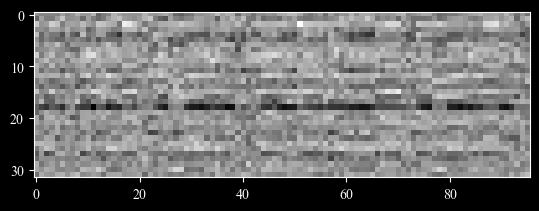

In [64]:
plt.imshow(lh[:, :32 * 3], cmap='gray')

In [133]:
pred.shape

(32, 80)

Array(0.00507812, dtype=float32)

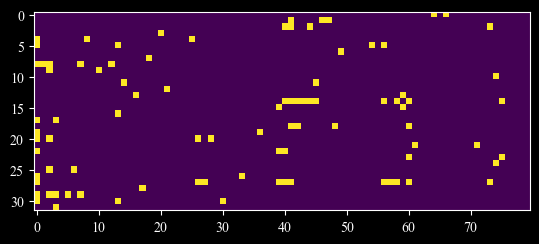

In [67]:
plt.imshow(cat)